In [1634]:
from reliability.Distributions import Weibull_Distribution
from reliability.Fitters import Fit_Weibull_2P
from reliability.Probability_plotting import plot_points, plotting_positions, Weibull_probability_plot
from reliability.Utils import axes_transforms, probability_plot_xylims, probability_plot_xyticks, linear_regression
from reliability.Distributions import Weibull_Distribution

import matplotlib.pyplot as plt
import matplotlib as mpl

from cycler import cycler
from matplotlib import colors, colormaps
import matplotlib.ticker as mticker
import pandas as pd
from matplotlib.figure import figaspect
import seaborn as sns
import numpy as np
from scipy.special import gamma
from scipy.stats import weibull_min, linregress
import itertools

# Configuration

In [1635]:
angle_method = True ## Calculate strength via fracture angle or simple diameter
design_prob = 1-0.01 ## Desired quantile of survival for design

In [1636]:
stress_label = "Failure stress (MPa)"
v_label = "Sample volume ($mm^3$)"
sa_label = "Surface area ($mm^2$)"

In [1637]:
plt.style.use('seaborn-v0_8-ticks')
mpl.rcParams["lines.linewidth"] = 1.5
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["scatter.marker"] = "."

In [1638]:
marker_cycler = itertools.cycle(("o", "^", "x", "+"))

# Example

Results from Fit_Weibull_2P (95% CI):
Analysis method: Least Squares Estimation (RRX)
Failures / Right censored: 20/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         28.1297          3.6749   21.7752   36.3385
     Beta         1.80611        0.316663   1.28087   2.54674 

Goodness of fit    Value
 Log-likelihood  -79.565
           AICc  163.836
            BIC  165.121
             AD 0.817695 



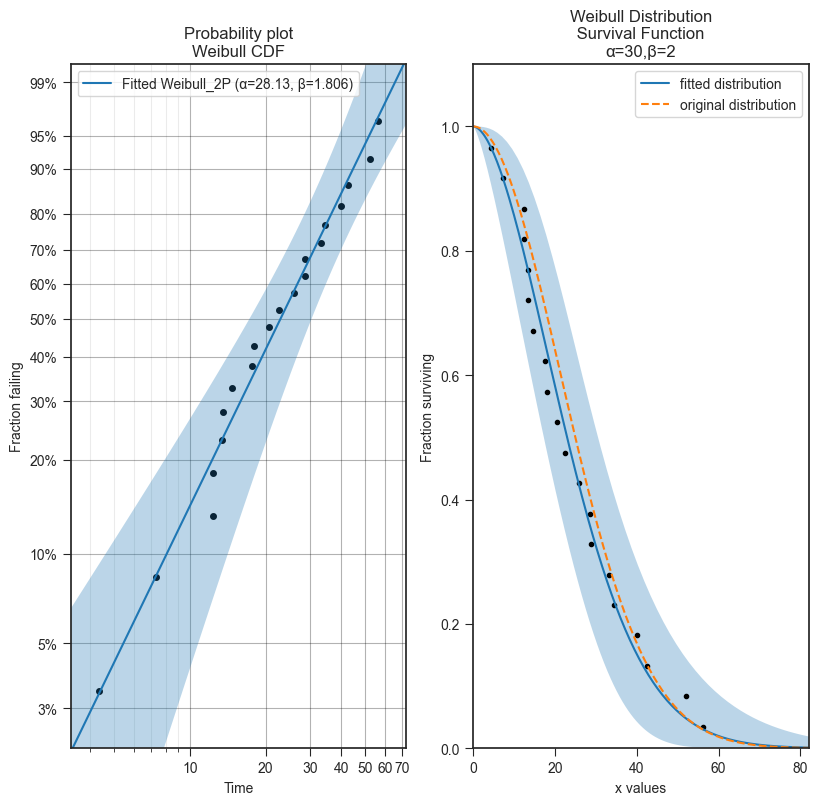

In [1639]:
example_dist = Weibull_Distribution(alpha=30, beta=2)  # creates the distribution object
example_data = example_dist.random_samples(20, seed=42)  # draws 20 samples from the distribution. Seeded for repeatability
plt.subplot(121)
fit = Fit_Weibull_2P(failures=example_data, method="LS")  # fits a Weibull distribution to the data and generates the probability plot
plt.subplot(122)
fit.distribution.SF(label='fitted distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
example_dist.SF(label='original distribution', linestyle='--') # plots the survival function of the original distribution
plot_points(failures=example_data, func='SF')  # overlays the original data on the survival function
plt.legend()
plt.show()

In [1640]:
example_data

array([20.55094355, 52.04910458, 34.42486201, 28.66440822, 12.355662  ,
       12.35462111,  7.33858922, 42.54536142, 28.76063174, 33.28851237,
        4.32658956, 56.15337681, 40.09721423, 14.65670027, 13.43916254,
       13.50371358, 18.06871209, 25.87537532, 22.56065957, 17.60115602])

# 3.5mm Sample Test

In [1641]:
test_data = pd.read_csv("Test_data.csv")

test_data

,Unnamed: 0,Proben-Nr.,Datum/Uhrzeit,Fcr,...,Moment,failure stress,Unnamed: 10,Diameter.1
0,NaN,NaN,NaN,N,...,Nmm,N/mm^2,NaN,mm
1,Probe 1,1,45420.6,22.85162354,...,342.8,76.7,NaN,3.57
2,Probe 2,2,45420.7,22.49817848,...,337.5,74.9,NaN,3.58
3,Probe 3,3,45420.7,18.44078827,...,276.6,62.4,NaN,3.56
4,Probe 4,4,45420.7,22.20804024,...,333.1,79.8,NaN,3.49
5,Probe 5,5,45420.7,23.90054512,...,358.5,83.7,NaN,3.52
6,Probe 6,6,45420.7,25.65187645,...,384.8,87.6,NaN,3.55
7,Probe 7,7,45420.7,26.03781509,...,390.6,87.4,NaN,3.57
8,Probe 8,8,45420.7,26.57203484,...,398.6,93.1,NaN,3.52
9,Probe 9,9,45420.7,18.93573761,...,284.0,65.8,NaN,3.53


In [1642]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(test_data):
    # Drop columns: 'Unnamed: 0', 'Unnamed: 10'
    test_data = test_data.drop(columns=['Unnamed: 0', 'Unnamed: 10'])
    # Drop rows with missing data in column: 'Proben-Nr.'
    test_data = test_data.dropna(subset=['Proben-Nr.'])
    # Change column type to uint32 for column: 'Proben-Nr.'
    test_data = test_data.astype({'Proben-Nr.': 'uint32'})
    # Rename column 'Proben-Nr.' to 'Probe_Num'
    test_data = test_data.rename(columns={'Proben-Nr.': 'Probe_Num'})
    return test_data

test_data_clean = clean_data(test_data.copy())
test_data_clean.head()

,Probe_Num,Datum/Uhrzeit,Fcr,Diameter,...,span,Moment,failure stress,Diameter.1
1,1,45420.6,22.85162354,3.57,...,30.0,342.8,76.7,3.57
2,2,45420.7,22.49817848,3.58,...,30.0,337.5,74.9,3.58
3,3,45420.7,18.44078827,3.56,...,30.0,276.6,62.4,3.56
4,4,45420.7,22.20804024,3.49,...,30.0,333.1,79.8,3.49
5,5,45420.7,23.90054512,3.52,...,30.0,358.5,83.7,3.52


In [1643]:
test_fail_data = test_data_clean['failure stress'].to_numpy(dtype="float32")
test_fail_data

array([ 76.7,  74.9,  62.4,  79.8,  83.7,  87.6,  87.4,  93.1,  65.8,
        71.2,  71.6,  89.5, 101.6, 105. ,  74.3,  78. ,  92. ,  94.6,
        81.5,  73.4,  79. ,  89.7,  83.6,  86.5, 115.6,  81.6,  60.4,
        87.8,  86.3, 102. ,  72.4,  85.9], dtype=float32)

Results from Fit_Weibull_2P (95% CI):
Analysis method: Least Squares Estimation (RRY)
Failures / Right censored: 32/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         88.6653         2.15064   84.5487   92.9823
     Beta         7.99328        0.968069   6.30428   10.1348 

Goodness of fit    Value
 Log-likelihood -127.807
           AICc  260.028
            BIC  262.546
             AD  1.07659 



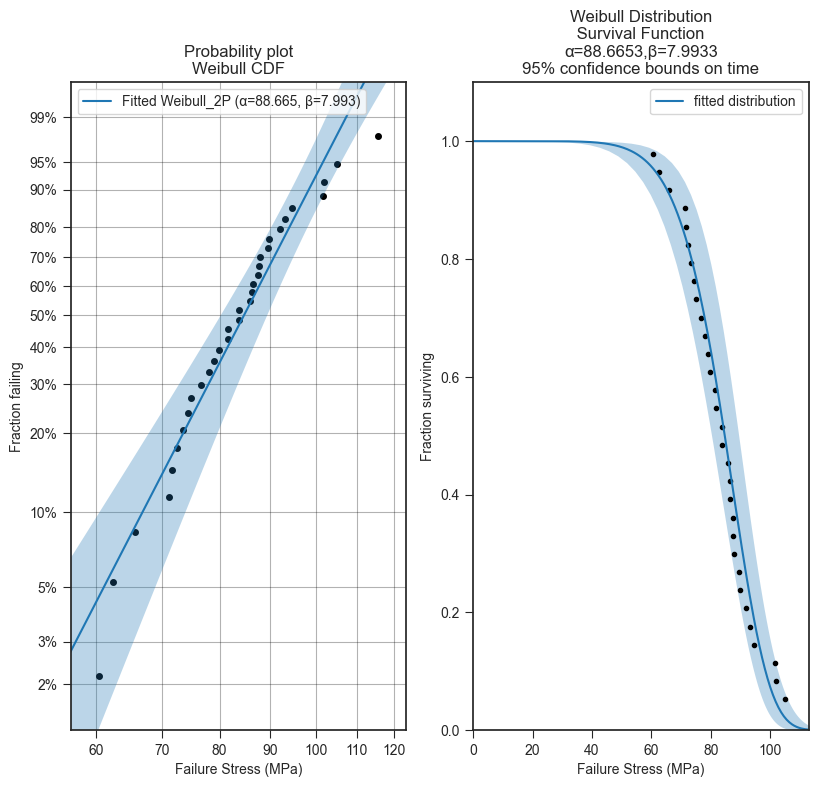

In [1644]:
plt.clf()
plt.subplot(121)
test_fit = Fit_Weibull_2P(failures=test_fail_data, method="LS")  # fits a Weibull distribution to the data and generates the probability plot
plt.xlabel("Failure Stress (MPa)")
plt.subplot(122)
test_fit.distribution.SF(label='fitted distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
plot_points(failures=test_fail_data, func='SF')  # overlays the original data on the survival function
plt.legend()
plt.xlabel("Failure Stress (MPa)")
plt.show()

In [1645]:
test_fail_data

array([ 76.7,  74.9,  62.4,  79.8,  83.7,  87.6,  87.4,  93.1,  65.8,
        71.2,  71.6,  89.5, 101.6, 105. ,  74.3,  78. ,  92. ,  94.6,
        81.5,  73.4,  79. ,  89.7,  83.6,  86.5, 115.6,  81.6,  60.4,
        87.8,  86.3, 102. ,  72.4,  85.9], dtype=float32)

In [1646]:
val_test = -8

test_fail_data[val_test]

np.float32(115.6)

In [1647]:
cdf_test = test_fit.distribution.CDF(xvals=[test_fail_data[val_test]], show_plot=False) ## Calculates values along the line

print(test_fail_data[val_test], " ", cdf_test)

115.6   0.9997598194127818


In [1648]:
test_points = plotting_positions(test_fail_data) ## Calculates where the points on the scatter should go

print(test_points[0][val_test], " ", test_points[1][val_test])

115.5999984741211   0.9783950617283951


# Load in and clean data

In [1649]:
gcc_data = pd.read_csv("Maple Rod Testing Analysis.csv")

gcc_data

,sample,fracture_load,fracture_stress,fracture_diameter,support_span,load_span,Unnamed: 6
0,B1,46.7887,67.761,5.23,185,70,NaN
1,B2,85.8979,170.977,5.28,185,70,NaN
2,B3,54.1228,102.886,5.3,185,70,NaN
3,B4,64.6418,122.189,5.31,185,70,NaN
4,B5,78.9588,174.763,5.09,185,70,NaN
5,B6,57.2761,116.623,5.18,185,70,NaN
6,B7,68.1001,128.726,5.31,185,70,NaN
7,B8,80.9788,162.4,5.24,185,70,NaN
8,B9,56.073,108.539,5.22,185,70,NaN
9,B10,92.3955,179.794,5.32,185,70,NaN


In [1650]:
stiff_data = pd.read_csv("Stiffness\\Rod_stiffness_20250317-1030.csv")

stiff_data

,sample,stiff_slope,stiff_intercept,stiff_rvalue,stiff_rsquared,stiff_stderr,stiff_intercept_stderr
0,F1,1175.09,-5107.11,0.994105,0.988245,6.87005,38.4487
1,F2,1580.02,-8504.05,0.999495,0.99899,1.54694,10.7085
2,F3,1526.92,-7088.74,0.99948,0.99896,1.68071,10.0769
3,F4,2221.75,-10994.2,0.99756,0.995125,6.47367,38.0755
4,E1,443.757,-1838.61,0.996717,0.993445,1.68249,9.77643
5,E2,453.549,-1891.4,0.995984,0.991984,1.90922,11.0532
6,E3,598.983,-2739.42,0.995609,0.991238,2.09437,12.5437
7,E4,475.373,-1916.99,0.997402,0.994811,1.63854,9.16929
8,X1,372.65,-1544.1,0.998809,0.99762,0.592744,3.76905
9,X2,451.289,-1990.15,0.997132,0.994272,1.47,8.98928


In [1651]:
gcc_data = pd.merge(gcc_data, stiff_data, on="sample")

gcc_data

,sample,fracture_load,fracture_stress,fracture_diameter,...,stiff_rvalue,stiff_rsquared,stiff_stderr,stiff_intercept_stderr
0,B1,46.7887,67.761,5.23,...,0.999346,0.998693,0.017214,0.0434286
1,B2,85.8979,170.977,5.28,...,0.999592,0.999184,0.0146036,0.0692124
2,B3,54.1228,102.886,5.3,...,0.999528,0.999056,0.0178639,0.0592741
3,B4,64.6418,122.189,5.31,...,0.999602,0.999203,0.0155251,0.0547607
4,B5,78.9588,174.763,5.09,...,0.999707,0.999414,0.0179146,0.0794565
5,B6,57.2761,116.623,5.18,...,0.999592,0.999184,0.0276003,0.0993303
6,B7,68.1001,128.726,5.31,...,0.999816,0.999632,0.0168685,0.0582159
7,B8,80.9788,162.4,5.24,...,0.999714,0.999428,0.0201934,0.082028
8,B9,56.073,108.539,5.22,...,0.999762,0.999525,0.020953,0.0657883
9,B10,92.3955,179.794,5.32,...,0.999899,0.999798,0.0119736,0.0576809


In [1652]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(gcc_data):
    # Drop rows with missing data in column: 'fracture_stress'
    gcc_data = gcc_data.dropna(subset=['fracture_stress'])
    gcc_data = gcc_data.dropna(how="all", axis=1)
    return gcc_data

gcc_data_clean = clean_data(gcc_data.copy())
gcc_data_clean.head()

,sample,fracture_load,fracture_stress,fracture_diameter,...,stiff_rvalue,stiff_rsquared,stiff_stderr,stiff_intercept_stderr
0,B1,46.7887,67.761,5.23,...,0.999346,0.998693,0.017214,0.0434286
1,B2,85.8979,170.977,5.28,...,0.999592,0.999184,0.0146036,0.0692124
2,B3,54.1228,102.886,5.3,...,0.999528,0.999056,0.0178639,0.0592741
3,B4,64.6418,122.189,5.31,...,0.999602,0.999203,0.0155251,0.0547607
4,B5,78.9588,174.763,5.09,...,0.999707,0.999414,0.0179146,0.0794565


In [1653]:
gcc_data_clean["series"] = gcc_data_clean["sample"].str[0] ## Extract series letter from the "sample" column

gcc_data_clean = gcc_data_clean.drop(gcc_data_clean[gcc_data_clean["sample"] == "D5"].index) ## Drop this outlier for now, remember to determine if this needs further inspection

gcc_data_clean = gcc_data_clean.drop(gcc_data_clean[gcc_data_clean["series"] == "X"].index) ## Drop the x series, these were just to test setup

gcc_data_clean = gcc_data_clean.drop(gcc_data_clean[gcc_data_clean["series"] == "L"].index) ## Drop the L series, we dont want it

gcc_data_clean = gcc_data_clean.drop(gcc_data_clean[gcc_data_clean["series"] == "J"].index) ## Drop the J series, its an outlier, determine if this needs further inspection

gcc_data_clean

,sample,fracture_load,fracture_stress,fracture_diameter,...,stiff_rsquared,stiff_stderr,stiff_intercept_stderr,series
0,B1,46.7887,67.761,5.23,...,0.998693,0.017214,0.0434286,B
1,B2,85.8979,170.977,5.28,...,0.999184,0.0146036,0.0692124,B
2,B3,54.1228,102.886,5.3,...,0.999056,0.0178639,0.0592741,B
3,B4,64.6418,122.189,5.31,...,0.999203,0.0155251,0.0547607,B
4,B5,78.9588,174.763,5.09,...,0.999414,0.0179146,0.0794565,B
5,B6,57.2761,116.623,5.18,...,0.999184,0.0276003,0.0993303,B
6,B7,68.1001,128.726,5.31,...,0.999632,0.0168685,0.0582159,B
7,B8,80.9788,162.4,5.24,...,0.999428,0.0201934,0.082028,B
8,B9,56.073,108.539,5.22,...,0.999525,0.020953,0.0657883,B
9,B10,92.3955,179.794,5.32,...,0.999798,0.0119736,0.0576809,B


# Analyse Strength

## Functions

In [1654]:
def simple_fracture_stress(load, support_span, load_span, diameter):
    ### Calculate fracture stress without accounting for fracture angle
    pin_distance = (support_span - load_span) / 2
    return (16 * load * pin_distance) / (np.pi * diameter**3)

In [1655]:
def calc_fracture_stress(sample_data):
    ### Batch calculate simple fracture stress
    sample_data["old_fracture_stress"] = sample_data["fracture_stress"]
    sample_data["fracture_stress"] = sample_data.apply(lambda row: simple_fracture_stress(row["fracture_load"], row["support_span"], row["load_span"], row["fracture_diameter"]), axis=1)
    return sample_data

In [1656]:
def fit_and_plot_weibull(data, design_failure):
    
    ## Some basic statistics of each series, in a separate dataframe
    data_anal = data[["series", "fracture_diameter", "fracture_stress"]].groupby("series").agg(['mean', "std"])
    data_anal.columns = data_anal.columns.map('_'.join)
    data_anal["fracture_stress_CV"] = data_anal["fracture_stress_std"] / data_anal["fracture_stress_mean"] * 100

    data_anal = data_anal.sort_values("fracture_diameter_mean")
    
    unique_values = data_anal.index.unique()
    
    w, h = figaspect(1.2)

    fracture_prob = pd.DataFrame()

    ind_fig, ind_ax = plt.subplots()
    collated_fig, collated_ax = plt.subplots()

    collated_min_x = 100
    collated_max_x = 100

    for letter in unique_values:
        fracture_frame = data.loc[data["series"] == letter, ["fracture_stress"]].copy()
        plot_data = fracture_frame.squeeze(axis=1).to_numpy(dtype="float32")

        data_anal.loc[letter, "support_span"] = data.loc[data["series"] == letter, "support_span"].iloc[0]
        data_anal.loc[letter, "load_span"] = data.loc[data["series"] == letter, "load_span"].iloc[0]

        if len(plot_data) < 2: continue

        collated_min_x = min(np.min(plot_data), collated_min_x)
        collated_max_x = min(np.max(plot_data), collated_max_x)
        
        avg_diameter = data_anal.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.2f mm dia." % (letter, avg_diameter)
        
        plt.sca(ind_ax)
        ## Fit the current data to a weibull
        fracture_fit = Fit_Weibull_2P(failures=plot_data, print_results=False, label=legend_text, method="LS", CI_type="none")  # fits a Weibull distribution to the data and generates the probability plot

        ind_fig.set_size_inches(7, 8)
        plt.ylabel("Probability of failure")
        plt.xlabel(stress_label)
        plt.title("")
        ind_fig.savefig("Figs/series_" + letter, bbox_inches = "tight")
        
        ind_ax.cla()

        fail_x, fail_y = plotting_positions(plot_data)

        fracture_frame.loc[:, "Fail Check"] = fail_x
        fracture_frame.loc[:, "Fail Prob"] = fail_y

        fracture_frame["char_strength"] = fracture_fit.alpha
        fracture_frame["weibull_modulus"] = fracture_fit.beta

        fracture_frame = fracture_frame.drop(["fracture_stress"], axis=1)

        fracture_prob =  pd.concat([fracture_prob, fracture_frame], axis=0)

        data_anal.loc[letter, "char_strength"] = fracture_fit.alpha
        data_anal.loc[letter, "weibull_modulus"] = fracture_fit.beta

        data_anal.loc[letter, "Design Strength"] = fracture_fit.distribution.inverse_SF(design_failure)

        collated_legend_text = "%s, dia.= ~%.2f mm" % (letter, avg_diameter)

        plt.sca(collated_ax)
        Weibull_probability_plot(failures=plot_data, __fitted_dist_params=fracture_fit.distribution, show_scatter_points=False, CI_type=None, label=collated_legend_text)
        plt.title("")
        plt.ylabel("Probability of failure")
        plt.xlabel(stress_label)

    ind_fig.clf()

    collated_fig.set_size_inches(7, 8)
    collated_ax.set_xlim([10, 300])
    collated_ax.set_ylim([0.1, 0.9])
    collated_fig.savefig("Figs/collated", bbox_inches = "tight")
    data = pd.concat([data, fracture_prob], axis=1)

    return data, data_anal

## Run Analysis

In [1657]:
if not angle_method:
    gcc_data_clean = calc_fracture_stress(gcc_data_clean)
    gcc_data_clean

<Figure size 700x800 with 0 Axes>

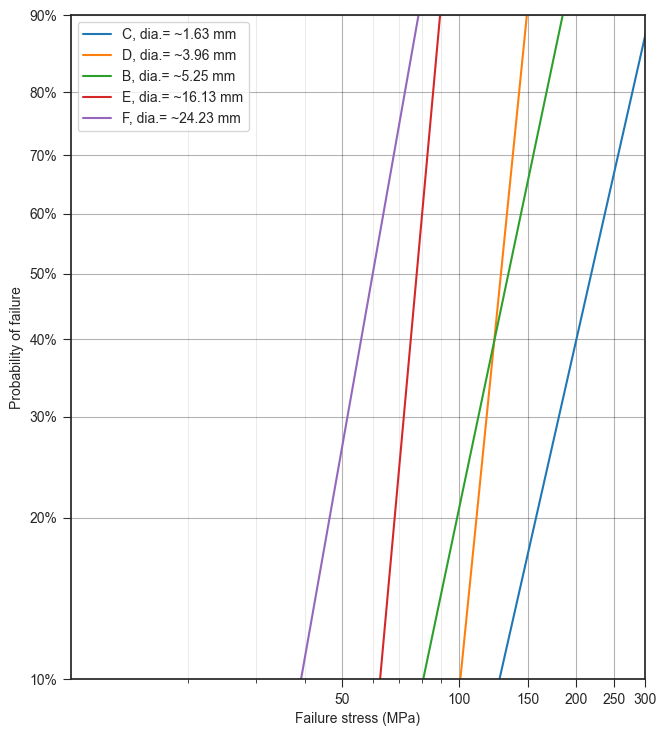

In [1658]:
gcc_data_clean, gcc_data_anal = fit_and_plot_weibull(gcc_data_clean, design_prob)

In [1659]:
gcc_data_clean

,sample,fracture_load,fracture_stress,fracture_diameter,...,Fail Check,Fail Prob,char_strength,weibull_modulus
0,B1,46.7887,67.761,5.23,...,67.761,0.0673077,147.631,3.73272
1,B2,85.8979,170.977,5.28,...,170.977,0.740385,147.631,3.73272
2,B3,54.1228,102.886,5.3,...,102.886,0.163462,147.631,3.73272
3,B4,64.6418,122.189,5.31,...,122.189,0.451923,147.631,3.73272
4,B5,78.9588,174.763,5.09,...,174.763,0.836538,147.631,3.73272
5,B6,57.2761,116.623,5.18,...,116.623,0.355769,147.631,3.73272
6,B7,68.1001,128.726,5.31,...,128.726,0.548077,147.631,3.73272
7,B8,80.9788,162.4,5.24,...,162.4,0.644231,147.631,3.73272
8,B9,56.073,108.539,5.22,...,108.539,0.259615,147.631,3.73272
9,B10,92.3955,179.794,5.32,...,179.794,0.932692,147.631,3.73272


In [1660]:
gcc_data_anal

,fracture_diameter_mean,fracture_diameter_std,fracture_stress_mean,fracture_stress_std,...,load_span,char_strength,weibull_modulus,Design Strength
series,,,,,,,,,
C,1.6275,0.115851,218.925,63.7101,...,90,243.097,3.46282,64.394
D,3.962,0.052451,126.708,18.0425,...,70,134.193,7.82771,74.5602
B,5.248,0.0725412,133.466,37.1229,...,70,147.631,3.73272,43.0488
E,16.13,0.0559762,77.1536,9.06919,...,40,81.0886,8.67882,47.7271
G,20.04,NaN,69.2194,NaN,...,24,NaN,NaN,NaN
H,23.95,NaN,74.6243,NaN,...,24,NaN,NaN,NaN
F,24.225,0.0957427,59.5653,12.8028,...,40,65.0795,4.43198,23.05
K,29.45,NaN,89.2743,NaN,...,24,NaN,NaN,NaN
I,33.38,NaN,66.0997,NaN,...,24,NaN,NaN,NaN


## Double check the alignment of probability data

In [1661]:
check_alignment = gcc_data_clean[["fracture_stress", "Fail Check"]].dropna()

check_alignment = np.isclose(check_alignment["fracture_stress"], check_alignment["Fail Check"])
check_alignment

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

# Size effect normalisation

## Functions

In [1662]:
def cylinder_gage_SA(diameter: float, length: float) -> float: return np.pi * diameter * length
def cylinder_gage_V(diameter: float, length: float) -> float: return (np.pi * diameter**2 * length) / 4

In [1663]:
def combined_gamma(modulus):
    return (gamma((modulus + 1) / 2) * gamma(3/2)) / (gamma((modulus + 4) / 2))

def effective_SA(gage_SA, load_span, support_span, modulus):
    comb_gamma = combined_gamma(modulus)
    return ((load_span / support_span) * modulus + 1) * ((modulus + 2) / 2) * (1/(modulus + 1)) * (comb_gamma / np.pi) * gage_SA

def effective_V(gage_V, load_span, support_span, modulus):
    comb_gamma = combined_gamma(modulus)
    return ((load_span / support_span) * modulus + 1) * (1/(modulus + 1)) * (comb_gamma / np.pi) * gage_V

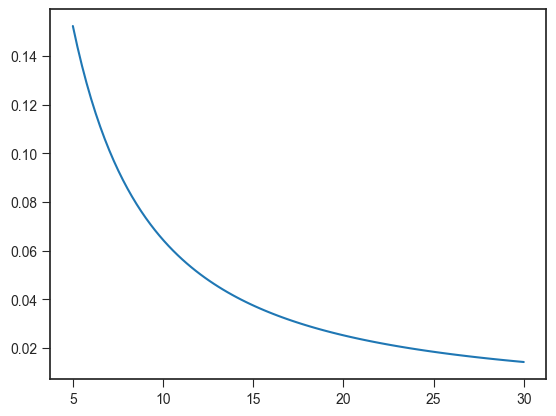

In [1664]:
gamma_test = np.linspace(5,30,100)
plt.plot(gamma_test, combined_gamma(gamma_test))

In [1665]:
effective_V(200, 60, 180, 5)

np.float64(4.311498987462984)

In [1666]:
effective_SA(1979, 60, 180, 3)

np.float64(209.9784215859072)

In [1667]:
def calc_sample_geometry(sample_data: pd.DataFrame, analysis_data: pd.DataFrame):
    sample_data["gage_V"] = sample_data.apply(lambda row: cylinder_gage_V(row["fracture_diameter"], row["support_span"]), axis=1)
    sample_data["gage_SA"] = sample_data.apply(lambda row: cylinder_gage_SA(row["fracture_diameter"], row["support_span"]), axis=1)

    calc_V_helper = lambda row: effective_V(row["gage_V"], row["load_span"],  row["support_span"], row["weibull_modulus"])
    calc_SA_helper = lambda row: effective_SA(row["gage_SA"], row["load_span"],  row["support_span"], row["weibull_modulus"])

    sample_data["effective_V"] = sample_data.apply(calc_V_helper, axis=1)
    sample_data["effective_SA"] = sample_data.apply(calc_SA_helper, axis=1)

    analysis_data["mean_gage_V"] = analysis_data.apply(lambda row: cylinder_gage_V(row["fracture_diameter_mean"], row["support_span"]), axis=1)
    analysis_data["mean_gage_SA"] = analysis_data.apply(lambda row: cylinder_gage_SA(row["fracture_diameter_mean"], row["support_span"]), axis=1)

    calc_V_helper = lambda row: effective_V(row["mean_gage_V"], row["load_span"],  row["support_span"], row["weibull_modulus"])
    calc_SA_helper = lambda row: effective_SA(row["mean_gage_SA"], row["load_span"],  row["support_span"], row["weibull_modulus"])

    analysis_data["mean_effective_V"] = analysis_data.apply(calc_V_helper, axis=1)
    analysis_data["mean_effective_SA"] = analysis_data.apply(calc_SA_helper, axis=1)

    return sample_data, analysis_data

In [1668]:
def scale_strength(strength, effective_size, modulus):
    return strength * (effective_size ** (1/modulus))

In [1669]:
scale_strength(np.array([5,5,5]), np.array([20,20,20]),np.array([5,5,5]))

array([9.10282102, 9.10282102, 9.10282102])

In [1670]:
def size_effect_normalize(original_prob: float, original_size: float, standard_size: float) -> float:
    size_ratio = standard_size / original_size
    return 1 - (1 - original_prob)**size_ratio

In [1671]:
def normalize_data(data):
    ## Normalised to a standard size, 1
    data["Fail Prob V Adj"] = data.apply(lambda row: size_effect_normalize(row["Fail Prob"], row["effective_V"], 1), axis=1)
    data["Fail Prob SA Adj"] = data.apply(lambda row: size_effect_normalize(row["Fail Prob"], row["effective_SA"], 1), axis=1)

    return data

In [1672]:
def size_shift_data(sample_data, analysis_data):
    sample_data["SA_scale_param"] = sample_data.apply(lambda row: scale_strength(row["fracture_stress"], row["effective_SA"], row["weibull_modulus"]), axis=1)
    sample_data["V_scale_param"] = sample_data.apply(lambda row: scale_strength(row["fracture_stress"], row["effective_V"], row["weibull_modulus"]), axis=1)
    
    analysis_data["SA_series_scale_param"] = analysis_data.apply(lambda row: scale_strength(row["char_strength"], row["mean_effective_SA"], row["weibull_modulus"]), axis=1)
    analysis_data["V_series_scale_param"] = analysis_data.apply(lambda row: scale_strength(row["char_strength"], row["mean_effective_V"], row["weibull_modulus"]), axis=1)

    return sample_data, analysis_data

In [1673]:
def fit_normalized_data(data, method):
    if method == "V":
        method_column = "Fail Prob V Adj"
    elif method == "SA":
        method_column = "Fail Prob SA Adj"
    else:
        raise("Please choose a valid method, volume (V) or surface area (SA)")
    
    least_squares_data = data[["fracture_stress", method_column]].dropna()

    stress = least_squares_data["fracture_stress"].to_numpy()
    fail_prob = least_squares_data[method_column].to_numpy()

    x = np.log(stress)
    y = np.log(-np.log(1-fail_prob))

    # m, c = linear_regression(x=x,y=y,RRX_or_RRY="RRX",show_plot=True,label='RRX')
    # m, c = linear_regression(x=x,y=y,RRX_or_RRY="RRY",show_plot=True,label='RRY')

    result = linregress(x, y)

    beta = result.slope
    alpha = np.exp(-result.intercept / beta)

    return (alpha, beta, result.rvalue)
    

In [1674]:
# def fit_normalized_data(data, method):
#     if method == "V":
#         method_column = "V_scale_param"
#     elif method == "SA":
#         method_column = "SA_scale_param"
#     else:
#         raise("Please choose a valid method, volume (V) or surface area (SA)")
    
#     least_squares_data = data[[method_column, "Fail Prob"]].dropna()

#     stress = least_squares_data[method_column].to_numpy()
#     fail_prob = least_squares_data["Fail Prob"].to_numpy()

#     x = np.log(stress)
#     y = np.log(-np.log(1-fail_prob))

#     m, c = np.polyfit(x, y, 1)

#     beta = m
#     alpha = np.exp(-c / beta)

#     return (alpha, beta)

In [1675]:
def plot_normalized_weibull(data, analysed_data):
    normalise_unique_series = analysed_data.dropna().index.unique()

    v_alpha, v_beta, v_r = fit_normalized_data(data, "V")
    sa_alpha, sa_beta, sa_r = fit_normalized_data(data, "SA")

    v_dist = Weibull_Distribution(alpha=v_alpha, beta=v_beta)
    sa_dist = Weibull_Distribution(alpha=sa_alpha, beta=sa_beta)
    
    v_dist_x = np.linspace(40, 300, 200)
    v_dist_y = v_dist.CDF(xvals=v_dist_x, show_plot=False)

    sa_dist_x = np.linspace(40, 300, 200)
    sa_dist_y = sa_dist.CDF(xvals=sa_dist_x, show_plot=False)

    plt.clf()
    fig, (ax_v, ax_sa) = plt.subplots(1,2, layout="constrained")
    fit_label_fmt = "{}-scaled Weibull Distribution:\n $\\sigma_o = {:.2f}$, $m = {:.2f}$"
    ax_v.plot(v_dist_x, v_dist_y, "--r", label=fit_label_fmt.format("Volume", v_alpha, v_beta))
    ax_sa.plot(sa_dist_x, sa_dist_y, "--r", label=fit_label_fmt.format("Surface area", sa_alpha, sa_beta))

    # color = iter(plt.cm.Dark2(np.linspace(0, 1, len(normalise_unique_series))))
    # title_text = method_title + " Normalised Weibull Probability\nScale= %.2f MPa  Shape= %.2f" % (alpha, beta)

    for i, letter in enumerate(normalise_unique_series):
        plot_data = data.loc[data["series"] == letter]


        # c = next(color)

        avg_diameter = analysed_data.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.2f mm" % (letter, avg_diameter)
        ax_v.scatter(data=plot_data, x="fracture_stress", y="Fail Prob V Adj", label=legend_text, marker=next(marker_cycler))
        ax_sa.scatter(data=plot_data, x="fracture_stress", y="Fail Prob SA Adj", label=legend_text, marker=next(marker_cycler))

    ax_v.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_v.set_xscale("log")

    ax_sa.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_sa.set_xscale("log")

    plt.sca(ax_v)
    probability_plot_xyticks()
    probability_plot_xylims(v_dist_x, v_dist_y, "weibull")

    plt.sca(ax_sa)
    probability_plot_xyticks()
    probability_plot_xylims(v_dist_x, v_dist_y, "weibull")

    ax_v.set_xlabel(stress_label)
    ax_v.set_ylabel("Probability of failure")
    # ax.set_title(title_text)

    ax_sa.set_xlabel(stress_label)
    ax_sa.set_ylabel("Probability of failure")

    ax_v.grid(zorder=2)
    ax_v.set_axisbelow(True)
    ax_v.legend()

    ax_sa.grid(zorder=2)
    ax_sa.set_axisbelow(True)
    ax_sa.legend()

    plt.gcf().set_size_inches(12, 9)

    return v_dist, sa_dist

In [1676]:
# def plot_normalized_weibull(data, analysed_data, alpha, beta, method):
#     if method == "V":
#         method_column = "V_scale_param"
#         method_title = "volume"
#     elif method == "SA":
#         method_column = "SA_scale_param"
#         method_title = "surface_area"
#     else:
#         raise("Please choose a valid method, volume (V) or surface area (SA)")

#     normalise_unique_series = data.dropna()["series"].unique()
    
#     normal_dist_x = np.linspace(100,1000000, 200)
#     normalised_dist_y = Weibull_Distribution(alpha=alpha, beta=beta).CDF(xvals=normal_dist_x, show_plot=False)

#     fig, ax = plt.subplots(layout="constrained")
#     ax.plot(normal_dist_x, normalised_dist_y, label="Best Fit")

#     color = iter(plt.cm.Dark2(np.linspace(0, 1, len(normalise_unique_series))))
#     title_text = method_title + " Normalised Weibull Probability\nScale= %.2f MPa  Shape= %.2f" % (alpha, beta)

#     for i, letter in enumerate(normalise_unique_series):
#         plot_data = data.loc[data["series"] == letter]


#         c = next(color)

#         avg_diameter = analysed_data.loc[letter, "fracture_diameter_mean"]
#         legend_text = "%s series: ~%.2f mm" % (letter, avg_diameter)
#         ax.scatter(data=plot_data, x=method_column, y="Fail Prob", marker="^", color=c, label=legend_text)

#     ax.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
#     ax.set_xscale("log")

#     probability_plot_xyticks()
#     probability_plot_xylims(normal_dist_x, normalised_dist_y, "weibull")

#     ax.set_xlabel("Failure Stress (MPa)")
#     ax.set_ylabel("Probability of failure")
#     ax.set_title(title_text)

#     ax.grid(zorder=2)
#     ax.set_axisbelow(True)
#     ax.legend()
#     plt.gcf().set_size_inches(6, 9)
#     plt.show()

In [1677]:
def plot_strength_vs_size(analysis_data: pd.DataFrame):
    fig, (ax_v, ax_sa) = plt.subplots(1,2, sharey=True)
    fig.set_size_inches(12,6)
    ## fit and plot data on volume
    x_V_data = analysis_data["mean_gage_V"].to_numpy()
    y_V_data = analysis_data["fracture_stress_mean"].to_numpy()
    m, c = np.polyfit(np.log10(x_V_data), np.log10(y_V_data),1)

    x_fit = np.linspace(np.min(x_V_data), np.max(x_V_data), 100)
    y_fit = np.power(10, m * np.log10(x_fit) + c)

    v_eq = "$\\log(\\sigma) = %0.2f \\log(V) + %0.2f$" % (m, c)

    ax_v.plot(x_fit, y_fit, "--r", label=v_eq)
    ax_v.scatter(data=analysis_data, x="mean_gage_V", y="fracture_stress_mean", color="k", marker=".", label=None)
    ax_v.set_xscale("log")
    ax_v.set_yscale("log")

    plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter()) 
    plt.gca().yaxis.set_minor_formatter(mticker.ScalarFormatter())

    ax_v.grid(visible=True, which='major', linestyle='-')
    ax_v.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

    ax_v.set_xlabel(v_label)
    ax_v.set_ylabel(stress_label)
    ax_v.legend()

    ## fit and plot data on surface area\
    x_SA_data = analysis_data["mean_gage_SA"].to_numpy()
    y_SA_data = analysis_data["fracture_stress_mean"].to_numpy()
    m, c = np.polyfit(np.log10(x_SA_data), np.log10(y_SA_data),1)

    x_fit = np.linspace(np.min(x_SA_data), np.max(x_SA_data), 100)
    y_fit = np.power(10, m * np.log10(x_fit) + c)

    sa_eq = "$\\log(\\sigma) = %0.2f \\log(A) + %0.2f$" % (m, c)

    ax_sa.plot(x_fit, y_fit, "--r", label=sa_eq)
    ax_sa.scatter(data=analysis_data, x="mean_gage_SA", y="fracture_stress_mean", color="k", marker=".", label=None)
    ax_sa.set_xscale("log")
    # ax_sa.set_yscale("log")

    # plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter()) 
    # plt.gca().yaxis.set_minor_formatter(mticker.ScalarFormatter())

    ax_sa.grid(visible=True, which='major', linestyle='-')
    ax_sa.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

    ax_sa.set_xlabel(sa_label)
    # ax_sa.set_ylabel(stress_label)

    ax_sa.tick_params(which="both", labelleft=True)
    ax_sa.legend()
    fig.tight_layout()

In [1678]:
def plot_strength_vs_eff_size(analysis_data: pd.DataFrame):
    fig, ax = plt.subplots()
    plot_data = analysis_data.dropna()
    x_data = plot_data["mean_effective_V"].to_numpy()
    y_data = plot_data["char_strength"].to_numpy()
    m, c = np.polyfit(np.log10(x_data), np.log10(y_data),1)

    x_fit = np.linspace(np.min(x_data), np.max(x_data), 100)
    y_fit = np.power(10, m * np.log10(x_fit) + c)

    ax.plot(x_fit, y_fit)
    ax.scatter(data=analysis_data, x="mean_effective_V", y="char_strength")
    ax.set_xscale("log")
    ax.set_yscale("log")

    plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter()) 
    plt.gca().yaxis.set_minor_formatter(mticker.ScalarFormatter())

    ax.grid(visible=True, which='major', linestyle='-')
    ax.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

    ax.set_xlabel("Specimen volume ($mm^3$)")
    ax.set_ylabel("Mean Stress (MPa)")

    return(m)

## Perform Analysis

In [1679]:
gcc_data_clean, gcc_data_anal = calc_sample_geometry(gcc_data_clean, gcc_data_anal)
# gcc_data_clean, gcc_data_anal = size_shift_data(gcc_data_clean, gcc_data_anal)
gcc_data_clean = normalize_data(gcc_data_clean)

In [1680]:
gcc_data_clean

,sample,fracture_load,fracture_stress,fracture_diameter,...,effective_V,effective_SA,Fail Prob V Adj,Fail Prob SA Adj
0,B1,46.7887,67.761,5.23,...,136.585,299.427,0.000510029,0.000232684
1,B2,85.8979,170.977,5.28,...,139.209,302.29,0.00964051,0.00445119
2,B3,54.1228,102.886,5.3,...,140.265,303.435,0.00127166,0.000588035
3,B4,64.6418,122.189,5.31,...,140.795,304.007,0.00426192,0.00197609
4,B5,78.9588,174.763,5.09,...,129.37,291.412,0.0139024,0.0061959
5,B6,57.2761,116.623,5.18,...,133.986,296.565,0.0032763,0.00148154
6,B7,68.1001,128.726,5.31,...,140.795,304.007,0.00562524,0.00260917
7,B8,80.9788,162.4,5.24,...,137.108,300,0.00750934,0.00343899
8,B9,56.073,108.539,5.22,...,136.063,298.855,0.00220673,0.00100529
9,B10,92.3955,179.794,5.32,...,141.326,304.58,0.0189129,0.00882055


In [1681]:
gcc_data_anal

,fracture_diameter_mean,fracture_diameter_std,fracture_stress_mean,fracture_stress_std,...,mean_gage_V,mean_gage_SA,mean_effective_V,mean_effective_SA
series,,,,,,,,,
C,1.6275,0.115851,218.925,63.7101,...,303.728,746.49,15.5924,104.674
D,3.962,0.052451,126.708,18.0425,...,2280.82,2302.69,28.7724,142.739
B,5.248,0.0725412,133.466,37.1229,...,4001.74,3050.11,137.527,300.458
E,16.13,0.0559762,77.1536,9.06919,...,37803.4,9374.67,276.87,366.602
G,20.04,NaN,69.2194,NaN,...,46050.9,9191.8,NaN,NaN
H,23.95,NaN,74.6243,NaN,...,65773.9,10985.2,NaN,NaN
F,24.225,0.0957427,59.5653,12.8028,...,85268.6,14079.4,1712.77,909.513
K,29.45,NaN,89.2743,NaN,...,99452,13507.9,NaN,NaN
I,33.38,NaN,66.0997,NaN,...,127766,15310.5,NaN,NaN


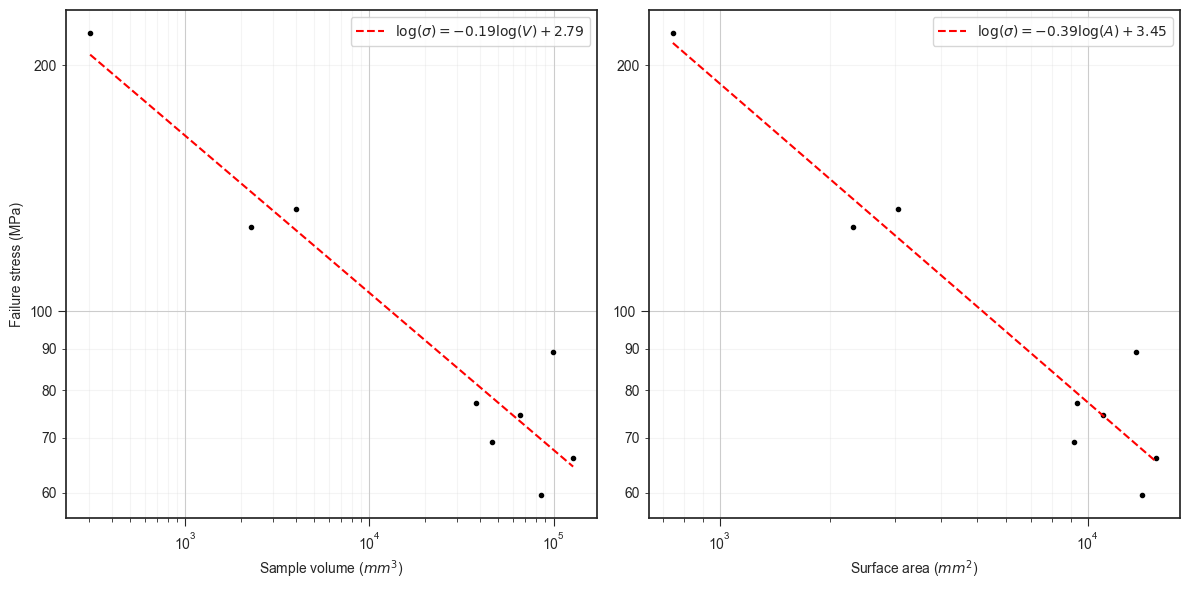

In [1682]:
plot_strength_vs_size(gcc_data_anal)

3.9645386917979275


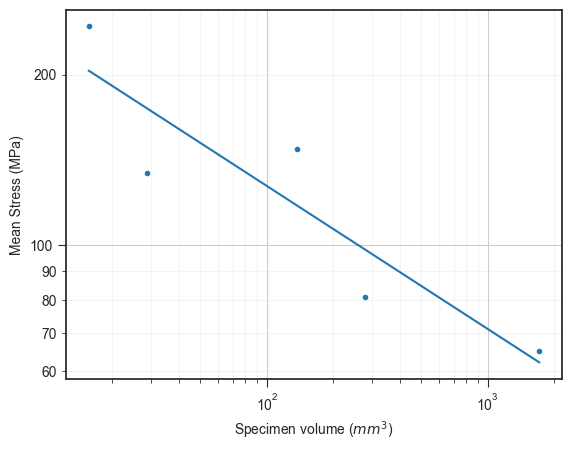

In [1683]:
k_v = plot_strength_vs_eff_size(gcc_data_anal)
print(-1/k_v)

### On volume

<Figure size 640x480 with 0 Axes>

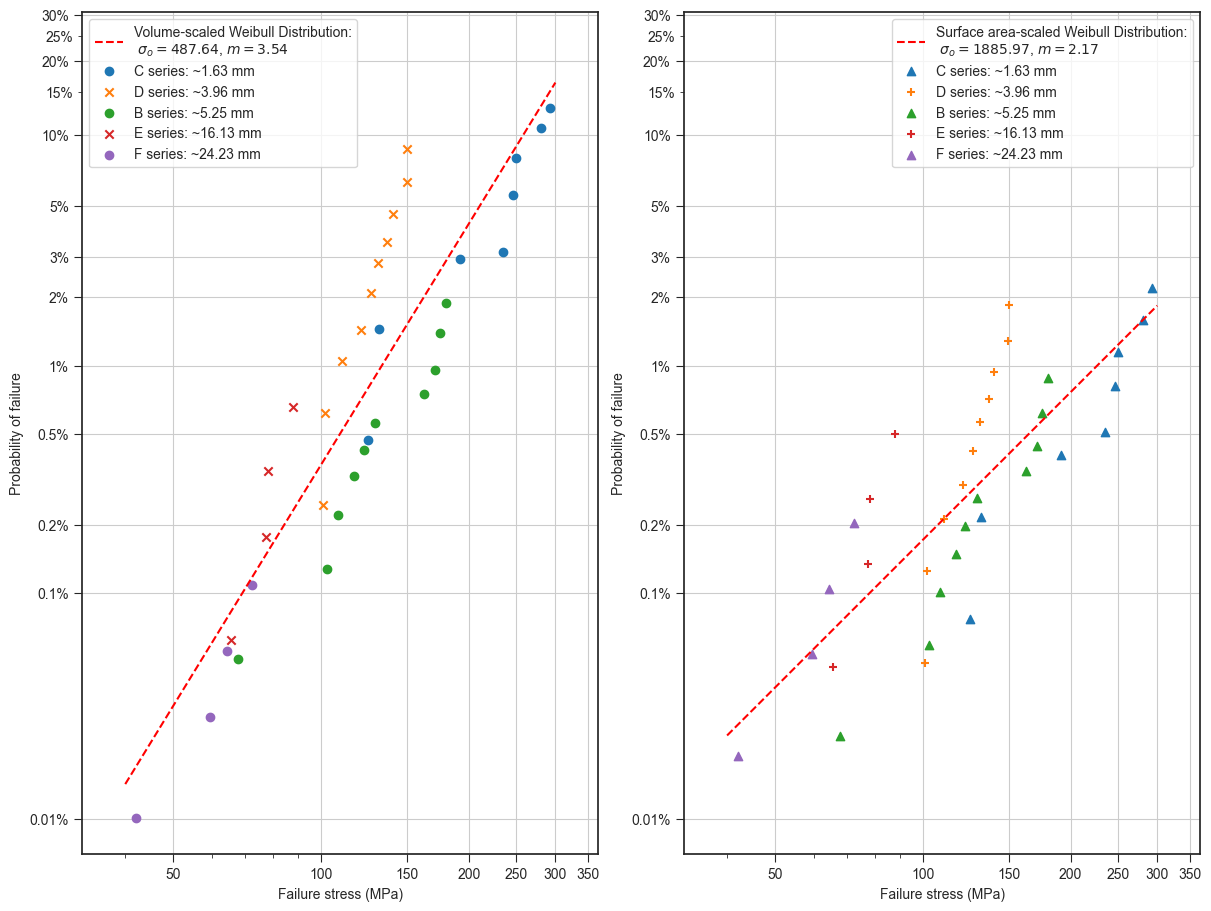

In [1684]:
v_dist, sa_dist = plot_normalized_weibull(gcc_data_clean, gcc_data_anal)

## Plotting relation from pooled data

In [1685]:
diameter_vals = np.linspace(1,30, 100)
support_span = 185
load_span = 70

plotting_dist = v_dist

design_strength = plotting_dist.inverse_SF(1-0.01)

print("1% Design strength is: ", design_strength)

1% Design strength is:  132.96282099182477


In [1686]:
gage_vol = cylinder_gage_V(diameter_vals, support_span)

eff_volume = effective_V(gage_vol, load_span, support_span, v_dist.beta)

scaled_strength = design_strength * (1 / eff_volume) ** (1 / v_dist.beta)

scaled_strength

array([82.8103457 , 71.62201043, 63.8172601 , 57.98928291, 53.43130198,
       49.74495603, 46.68669515, 44.09829075, 41.87197582, 39.93152533,
       38.22132936, 36.69975606, 35.3349482 , 34.10206571, 32.98142137,
       31.95718721, 31.01647616, 30.14867694, 29.34496372, 28.5979287 ,
       27.90130295, 27.24974148, 26.63865574, 26.06408182, 25.5225755 ,
       25.01112815, 24.52709858, 24.06815748, 23.63224175, 23.21751681,
       22.82234509, 22.44525979, 22.08494268, 21.7402054 , 21.40997349,
       21.09327278, 20.78921772, 20.4970013 , 20.21588637, 19.94519805,
       19.68431716, 19.43267448, 19.18974568, 18.95504692, 18.72813087,
       18.50858334, 18.29602012, 18.09008429, 17.8904438 , 17.69678928,
       17.50883209, 17.32630257, 17.14894849, 16.9765336 , 16.80883641,
       16.64564897, 16.48677588, 16.33203327, 16.18124803, 16.03425695,
       15.89090602, 15.7510498 , 15.61455079, 15.4812789 , 15.35111095,
       15.22393019, 15.09962587, 14.97809291, 14.85923144, 14.74

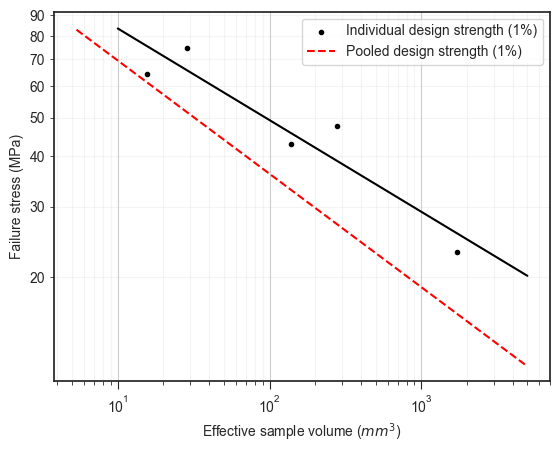

a =  -0.228450734597447
b =  2.1495543003699553


In [1687]:
fig, ax = plt.subplots()



eff_vol_fit = gcc_data_anal["mean_effective_V"].dropna().to_numpy()
design_strength_fit = gcc_data_anal["Design Strength"].dropna().to_numpy()

m, b = np.polyfit(np.log10(eff_vol_fit), np.log10(design_strength_fit), 1)

fit_x = np.linspace(10, 5000, 100)

fit_y = np.power(10, m * np.log10(fit_x) + b)

ax.plot(fit_x, fit_y, "-k")

ax.scatter(data=gcc_data_anal, x="mean_effective_V", y="Design Strength", label="Individual design strength (1%)", marker=".", color="k")

ax.plot(eff_volume, scaled_strength, "--r", label="Pooled design strength (1%)")
ax.set_xlabel("Effective sample volume ($mm^3$)")
ax.set_ylabel(stress_label)


ax.set_xscale("log")
ax.set_yscale("log")

plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter()) 
plt.gca().yaxis.set_minor_formatter(mticker.ScalarFormatter())

plt.legend()

ax.grid(visible=True, which='major', linestyle='-')
ax.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

plt.show()

print("a = ", m)
print("b = ", b)

# Stiffness Analysis

## Functions

In [1688]:
def circle_inertia(dia): return (np.pi * dia ** 4) / 64

def solve_for_modulus (slope, dia, support_span, load_span):
    lever = (support_span - load_span) / 2
    inertia = circle_inertia(dia)
    return (slope / (12 * inertia)) * (3 * support_span * lever **2 - 4 * lever**3) / 1000

In [1689]:
gcc_data_clean["elastic_mod"] = gcc_data_clean.apply(lambda x: solve_for_modulus(x["stiff_slope"], x["fracture_diameter"], x["support_span"], x["load_span"]), axis=1)
gcc_data_clean["elastic_mod_log"] = np.log10(gcc_data_clean["elastic_mod"])

gcc_data_clean

,sample,fracture_load,fracture_stress,fracture_diameter,...,Fail Prob V Adj,Fail Prob SA Adj,elastic_mod,elastic_mod_log
0,B1,46.7887,67.761,5.23,...,0.000510029,0.000232684,36.152,1.55813
1,B2,85.8979,170.977,5.28,...,0.00964051,0.00445119,42.4083,1.62745
2,B3,54.1228,102.886,5.3,...,0.00127166,0.000588035,35.4182,1.54923
3,B4,64.6418,122.189,5.31,...,0.00426192,0.00197609,37.6611,1.57589
4,B5,78.9588,174.763,5.09,...,0.0139024,0.0061959,46.3326,1.66589
5,B6,57.2761,116.623,5.18,...,0.0032763,0.00148154,41.4542,1.61757
6,B7,68.1001,128.726,5.31,...,0.00562524,0.00260917,38.9492,1.5905
7,B8,80.9788,162.4,5.24,...,0.00750934,0.00343899,43.3907,1.6374
8,B9,56.073,108.539,5.22,...,0.00220673,0.00100529,40.1393,1.60357
9,B10,92.3955,179.794,5.32,...,0.0189129,0.00882055,40.8347,1.61103


In [1690]:
# gcc_data_clean.to_excel("Rod_test_output.xlsx")

In [1691]:
stiff_anal = gcc_data_clean[["elastic_mod", "series"]].groupby("series").agg(['mean', "std"])
stiff_anal.columns = stiff_anal.columns.map('_'.join)

stiff_anal["elastic_mod_CV"] = stiff_anal["elastic_mod_std"] / stiff_anal["elastic_mod_mean"] * 100

stiff_anal

,elastic_mod_mean,elastic_mod_std,elastic_mod_CV
series,,,
B,40.274,3.36407,8.35294
C,88.0265,17.674,20.078
D,45.0531,2.88235,6.39768
E,17.2149,2.46355,14.3105
F,11.147,2.88827,25.9108
G,11.6128,NaN,NaN
H,7.00895,NaN,NaN
I,8.56661,NaN,NaN
K,11.8637,NaN,NaN


In [1692]:
gcc_data_anal = pd.merge(gcc_data_anal, stiff_anal, on="series")

gcc_data_anal["log_elastic_mod_mean"] = np.log10(gcc_data_anal["elastic_mod_mean"])

gcc_data_anal["cross_section"] = np.pi * (gcc_data_anal["fracture_diameter_mean"] ** 2)/4

gcc_data_anal

,fracture_diameter_mean,fracture_diameter_std,fracture_stress_mean,fracture_stress_std,...,elastic_mod_std,elastic_mod_CV,log_elastic_mod_mean,cross_section
series,,,,,,,,,
C,1.6275,0.115851,218.925,63.7101,...,17.674,20.078,1.94461,2.08033
D,3.962,0.052451,126.708,18.0425,...,2.88235,6.39768,1.65372,12.3287
B,5.248,0.0725412,133.466,37.1229,...,3.36407,8.35294,1.60503,21.631
E,16.13,0.0559762,77.1536,9.06919,...,2.46355,14.3105,1.2359,204.342
G,20.04,NaN,69.2194,NaN,...,NaN,NaN,1.06494,315.417
H,23.95,NaN,74.6243,NaN,...,NaN,NaN,0.845653,450.506
F,24.225,0.0957427,59.5653,12.8028,...,2.88827,25.9108,1.04716,460.911
K,29.45,NaN,89.2743,NaN,...,NaN,NaN,1.07422,681.178
I,33.38,NaN,66.0997,NaN,...,NaN,NaN,0.932809,875.11


In [1693]:
gcc_data_anal.to_excel("Rod_test_analysis.xlsx")

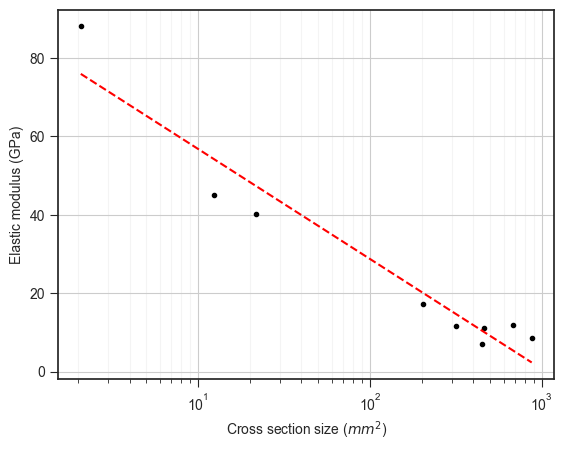

In [1694]:
fig, ax = plt.subplots()

ax.scatter(data=gcc_data_anal, x="cross_section", y="elastic_mod_mean", color='k')

cross_section = gcc_data_anal["cross_section"].dropna().to_numpy()
elastic_mod = gcc_data_anal["elastic_mod_mean"].dropna().to_numpy()

m, b = np.polyfit(np.log10(cross_section), elastic_mod, 1)

fit_x = np.linspace(np.min(cross_section), np.max(cross_section), 100)

fit_y = m * np.log10(fit_x) + b

ax.plot(fit_x, fit_y, "--r")
ax.set_xlabel("Cross section size ($mm^2$)")
ax.set_ylabel("Elastic modulus (GPa)")

ax.grid(visible=True, which='major', linestyle='-')
ax.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

# ax = sns.regplot(data=gcc_data_anal, x="cross_section", y="log_elastic_mod_mean")
# ax.set(xlabel="Cross section size ($mm^2$)", ylabel="log(Elastic modulus) (GPa)", title="Elastic modulus vs. Cross Section")

ax.set_xscale("log")
# ax.set_yscale("log")

# Dog bone calcs

Results from Fit_Weibull_2P (95% CI):
Analysis method: Least Squares Estimation (RRX)
Failures / Right censored: 5/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         41.0949         1.36248   38.5094    43.854
     Beta         14.3896         5.44081   6.85812   30.1922 

Goodness of fit    Value
 Log-likelihood -11.9694
           AICc  33.9388
            BIC  27.1577
             AD  2.31519 



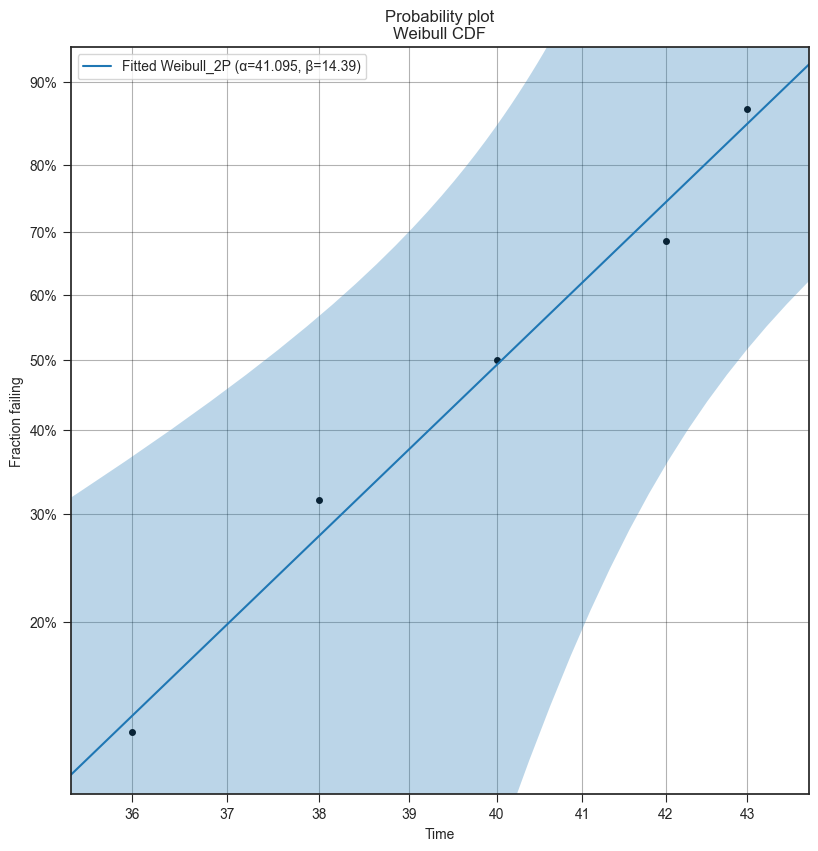

In [1695]:
bone_stress = np.array([36,38,40,42,43])

bone_fit = Fit_Weibull_2P(failures=bone_stress, method="LS")

In [1696]:
bone_fit.distribution.quantile(0.01)

np.float64(29.85044945740144)